Import Packages

In [1]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import glob
import json
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from utils import score, visualize_result, storeData, readData, create_sequences, setSeed
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import linregress
register_matplotlib_converters()


pollutant = ['O3', 'CO', 'NO2', 'SO2', 'PM2.5', 'PM10']
environment = ['RH', 'AMB_TEMP']


sgx_sensor_dict = {'c1_4#ec_na#0': 'O3',
                   'c1_0#ec_na#0': 'CO',
                   'c1_3#ec_na#0': 'NO2',
                   'c1_5#ec_na#0': 'SO2'}

unit_table = {'O3': 'ppb', 
              'CO': 'ppm',
              'NO2': 'ppb',
              'SO2': 'ppb'}


2023

In [2]:
ref_data = pd.read_csv('data/reference.csv', index_col = [0])
ref_data.index = pd.to_datetime(ref_data.index)
ref_data

,REF-O3,REF-CO,REF-NO2,REF-SO2,REF-PM2.5,REF-PM10,REF-RH,REF-AMB_TEMP
2023-01-01 00:00:00,38.7,0.23,4.8,1.0,14.0,14.0,86.0,18.4
2023-01-01 01:00:00,38.3,0.22,5.3,0.4,9.0,13.0,87.0,18.6
2023-01-01 02:00:00,38.3,0.22,4.4,0.2,6.0,8.0,89.0,18.5
2023-01-01 03:00:00,38.3,0.21,4.1,0.1,8.0,3.0,88.0,18.6
2023-01-01 04:00:00,38.2,0.20,3.9,0.5,5.0,4.0,88.0,18.9
...,...,...,...,...,...,...,...,...
2023-05-20 09:00:00,18.1,0.36,11.0,0.0,9.0,17.0,94.0,25.1
2023-05-20 10:00:00,20.9,0.51,14.5,0.0,12.0,22.0,93.0,25.6
2023-05-20 11:00:00,28.5,0.48,16.1,0.4,15.0,29.0,91.0,26.3
2023-05-20 12:00:00,47.3,0.35,11.0,0.3,15.0,21.0,90.0,26.4


SGX

In [3]:
sgx_data = pd.read_csv('data/sgx.csv', index_col = [0])
sgx_data.index = pd.to_datetime(sgx_data.index)
sgx_data

,SGX-O3,SGX-CO,SGX-NO2,SGX-SO2
measure_time,,,,
2023-01-01 08:00:00,-1.539167,6.763333,28.492500,115.645333
2023-01-01 09:00:00,-0.052000,5.354000,35.532833,143.715667
2023-01-01 10:00:00,-0.260333,5.516667,41.556333,168.006500
2023-01-01 11:00:00,-0.130000,5.578000,44.988500,184.928333
2023-01-01 12:00:00,-0.469000,6.089000,45.418000,196.317667
...,...,...,...,...
2023-05-20 03:00:00,-0.203667,8.544000,17.483000,90.725500
2023-05-20 04:00:00,-0.153390,8.346102,17.708983,89.421525
2023-05-20 05:00:00,-0.399500,8.478833,16.040167,83.241833


In [9]:
target_gas = 'CO'

data = pd.concat([ref_data, sgx_data], axis = 1)
data = data.reindex(data.index, fill_value=np.nan)
columns = ['REF-AMB_TEMP', 'REF-RH', 'SGX-CO', 'REF-CO']

# Find the days where there is any missing value in any of the columns
missing_days = data[columns].isnull().resample('D').sum().any(axis=1)

# Get the dates where there is at least one missing value
missing_days = missing_days[missing_days].index

# Remove these days from the original DataFrame
data = data[~data.index.normalize().isin(missing_days)]

data

,REF-O3,REF-CO,REF-NO2,REF-SO2,REF-PM2.5,REF-PM10,REF-RH,REF-AMB_TEMP,SGX-O3,SGX-CO,SGX-NO2,SGX-SO2
2023-01-02 00:00:00,30.3,0.23,6.9,0.4,9.0,9.0,87.0,19.6,-1.292500,6.147833,27.568833,109.301000
2023-01-02 01:00:00,31.6,0.20,5.2,0.3,5.0,8.0,86.0,19.6,-1.340500,5.257833,29.505833,109.353000
2023-01-02 02:00:00,33.3,0.18,4.2,0.3,4.0,8.0,86.0,19.5,-2.351000,5.095333,28.327500,108.810333
2023-01-02 03:00:00,31.7,0.19,4.4,0.5,12.0,7.0,89.0,19.1,-3.578000,5.951667,21.743333,95.864167
2023-01-02 04:00:00,30.5,0.18,4.5,0.3,9.0,6.0,90.0,19.1,-1.203000,4.208667,27.969000,105.332667
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-19 19:00:00,15.4,0.59,24.8,1.3,17.0,26.0,98.0,24.6,-7.565167,12.924333,15.221333,90.451500
2023-05-19 20:00:00,16.1,0.53,23.4,1.0,15.0,25.0,96.0,24.1,-6.081333,12.370167,15.548667,88.733833
2023-05-19 21:00:00,17.3,0.51,19.3,0.8,12.0,23.0,96.0,23.8,-4.011667,12.043167,14.580500,82.601667
2023-05-19 22:00:00,17.3,0.45,16.6,0.7,10.0,21.0,95.0,23.9,-2.487500,10.136000,15.786000,84.395500


In [5]:


time_list = ref_data.index.difference(sgx_data.index)

start_time = None
consecutive_hours = 0
consecutive_hours_list = []
result = []

for time_str in time_list:
    current_time = time_str
    
    if start_time is None:
        start_time = current_time
        consecutive_hours = 1
    else:
        if current_time - start_time == timedelta(hours=consecutive_hours):
            consecutive_hours += 1
        else:
            if consecutive_hours > 5:
                result.append(start_time)
                consecutive_hours_list.append(consecutive_hours)
            start_time = current_time
            consecutive_hours = 1

# Check if the last period exceeds 10 hours
if consecutive_hours > 5:
    result.append(start_time)
    consecutive_hours_list.append(consecutive_hours)

# Print the start times of consecutive periods exceeding 10 hours, and the length of each period
for i in range(len(result)):
    print(result[i], consecutive_hours_list[i])

print(sum(consecutive_hours_list))


2023-01-01 00:00:00 8
2023-01-17 21:00:00 11
2023-01-24 18:00:00 14
2023-02-11 19:00:00 13
2023-02-19 06:00:00 29
2023-02-22 18:00:00 14
2023-03-29 21:00:00 326
2023-04-12 21:00:00 11
2023-05-20 08:00:00 6
432


In [25]:
dates = sgx_data.loc[sgx_data.index.isin(ref_data.index), :].index

# Calculate the difference between the first element and the rest of the elements
diff_from_first = dates - dates[0]

# Convert the differences to hours
diff_in_hours = diff_from_first.total_seconds() / 3600

print(diff_in_hours)

Index([   0.0,    1.0,    2.0,    3.0,    4.0,    5.0,    6.0,    7.0,    8.0,
          9.0,
       ...
       3182.0, 3183.0, 3184.0, 3185.0, 3186.0, 3187.0, 3188.0, 3189.0, 3190.0,
       3191.0],
      dtype='float64', name='measure_time', length=2629)


In [4]:
data = pd.concat([ref_data, sgx_data], axis = 1)
data = data.reindex(data.index, fill_value=np.nan)
data.dropna()

,REF-O3,REF-CO,REF-NO2,REF-SO2,REF-PM2.5,REF-PM10,REF-RH,REF-AMB_TEMP,SGX-O3,SGX-CO,SGX-NO2,SGX-SO2
2023-01-01 08:00:00,33.3,0.28,7.2,0.4,7.0,3.0,83.0,20.0,-1.539167,6.763333,28.492500,115.645333
2023-01-01 09:00:00,33.2,0.30,7.7,0.4,5.0,6.0,78.0,21.1,-0.052000,5.354000,35.532833,143.715667
2023-01-01 10:00:00,35.3,0.28,6.9,0.3,2.0,7.0,68.0,22.1,-0.260333,5.516667,41.556333,168.006500
2023-01-01 11:00:00,37.2,0.25,5.7,0.4,2.0,5.0,64.0,22.6,-0.130000,5.578000,44.988500,184.928333
2023-01-01 12:00:00,37.8,0.27,5.5,0.5,5.0,6.0,61.0,22.9,-0.469000,6.089000,45.418000,196.317667
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-14 03:00:00,20.2,0.36,8.7,1.1,10.0,17.0,82.0,23.4,0.052000,8.064000,31.271500,101.954333
2023-05-14 04:00:00,22.5,0.34,6.2,1.0,8.0,17.0,81.0,23.3,0.000000,7.395833,31.068167,98.280500
2023-05-14 05:00:00,21.2,0.37,8.2,1.2,8.0,14.0,80.0,23.3,-0.026000,7.820167,31.146000,98.450667
2023-05-14 06:00:00,18.7,0.42,13.2,1.8,5.0,17.0,76.0,23.5,0.000000,8.657333,31.357833,101.921500


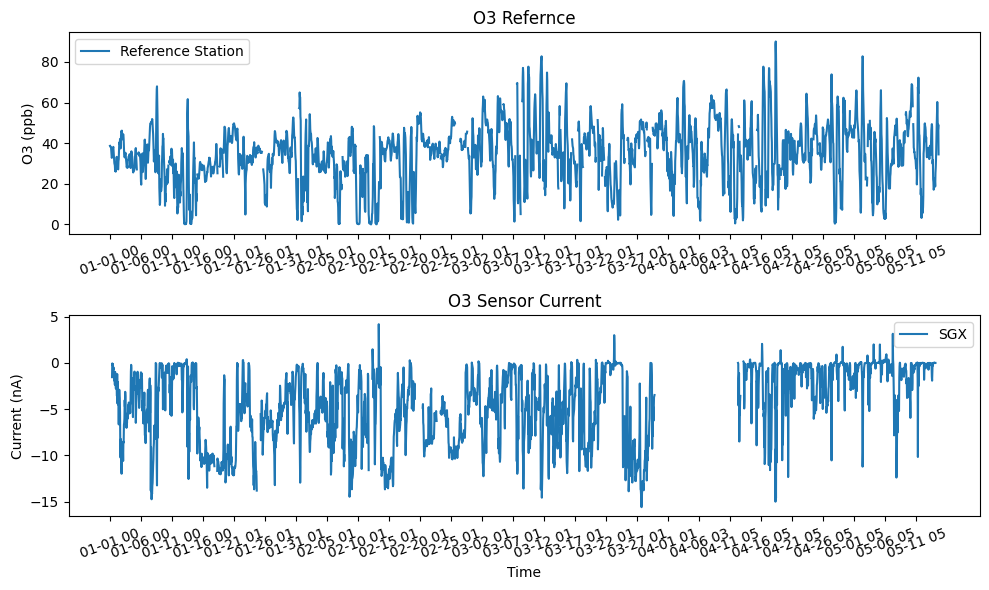

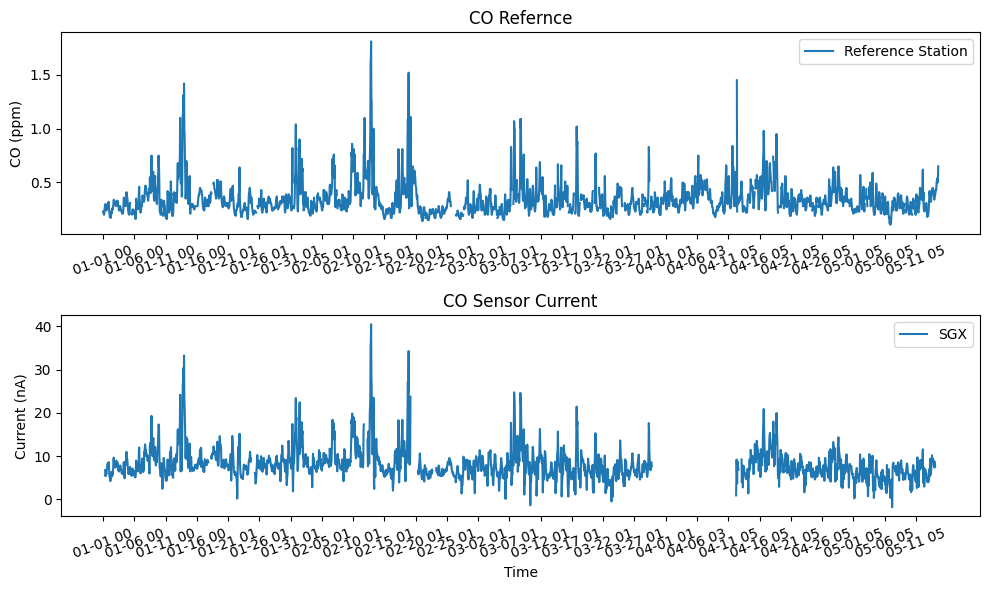

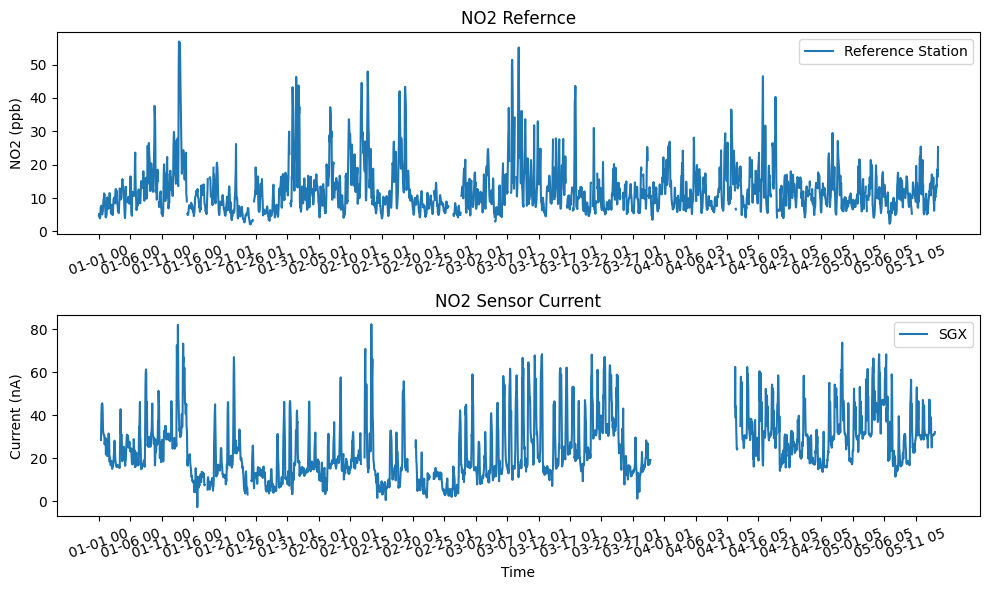

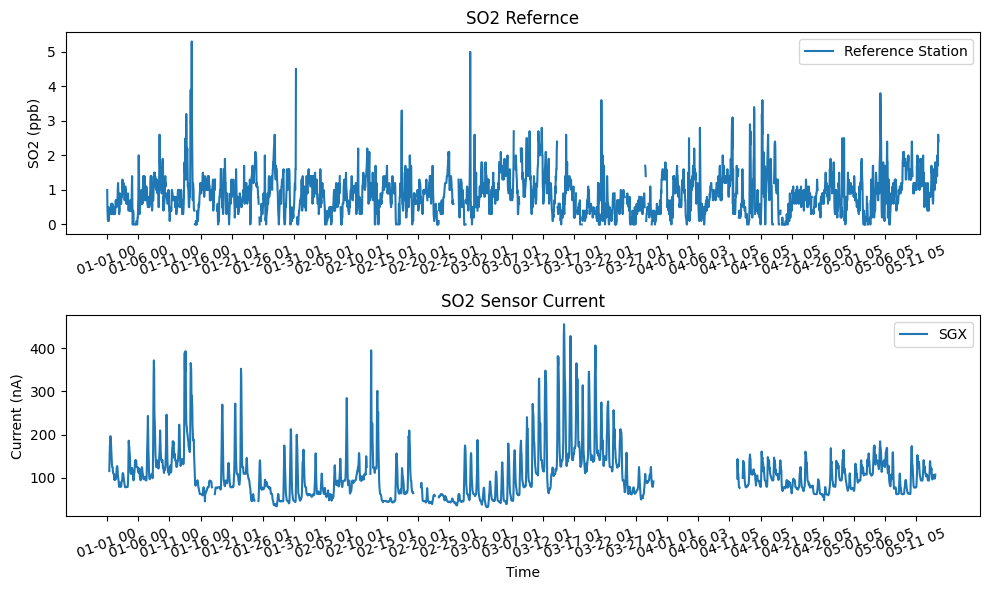

In [29]:
for gas in pollutant[:4]:
    labels = list(map(lambda x: str(x)[5:13], data.index[::120]))
    fig = plt.figure(figsize=(10, 6))

    ax1 = plt.subplot(211)
    ax1.set_title(f'{gas} Refernce')
    ax1.plot(data['REF-' + gas].values, label = 'Reference Station')
    ax1.legend()
    ax1.set_xticks(ticks = list(np.arange(0, len(data.index), 120)))
    ax1.set_xticklabels(labels = labels, rotation = 20)
    ax1.set_ylabel(f'{gas} ({unit_table[gas]})')
    

    ax2 = plt.subplot(212, sharex = ax1)
    ax2.set_title(f'{gas} Sensor Current')
    ax2.plot(data['SGX-' + gas].values, label = 'SGX')
    ax2.legend()
    ax2.set_xticks(ticks = list(np.arange(0, len(data.index), 120)))
    ax2.set_xticklabels(labels = labels, rotation = 20)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Current (nA)')

    plt.tight_layout()
    plt.savefig(f'fig/{gas}_comparison.png', dpi=300, bbox_inches='tight')


Correlation heatmap

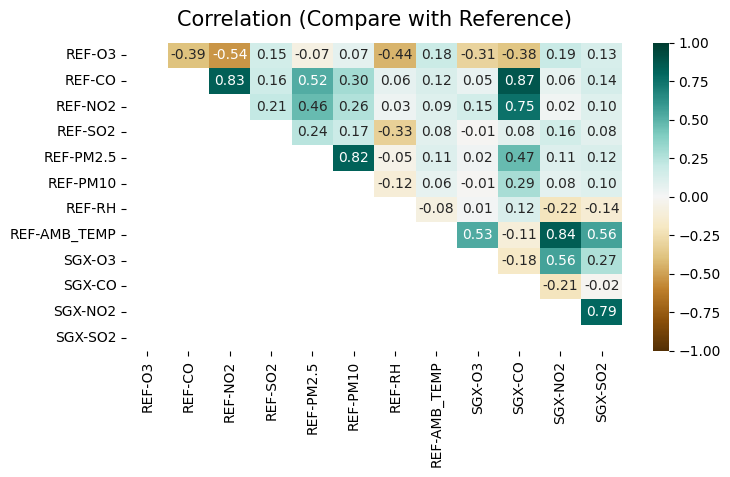

In [17]:
df = data.dropna().iloc[:, :12]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.tril(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', mask=mask, fmt=".2f")
heatmap.set_title('Correlation (Compare with Reference)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/correlation_heatmap_outer.png', dpi=300, bbox_inches='tight')

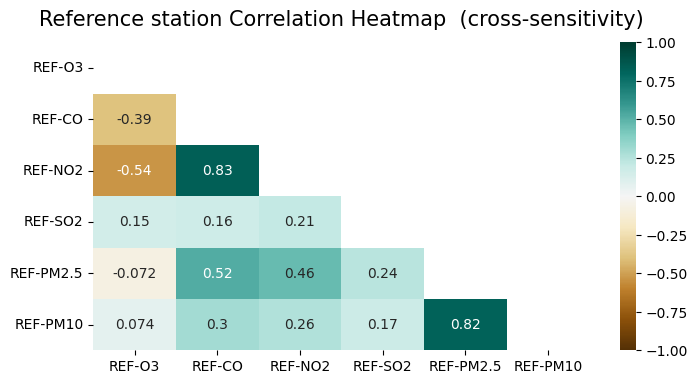

In [18]:
df = data.dropna().iloc[:, 0:6]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Reference station Correlation Heatmap  (cross-sensitivity)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/ref_correlation_heatmap.png', dpi=300, bbox_inches='tight')

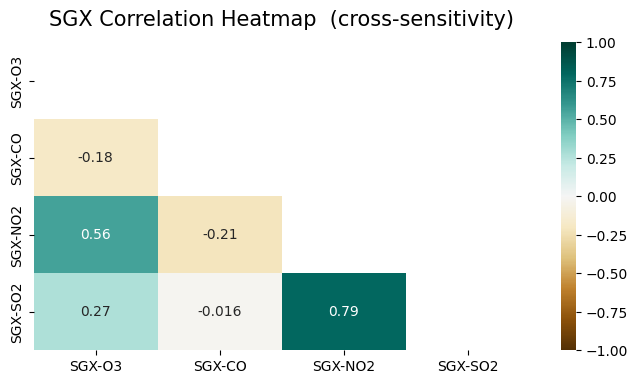

In [19]:
df = data.dropna().iloc[:, 8:12]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('SGX Correlation Heatmap  (cross-sensitivity)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/sgx_correlation_heatmap.png', dpi=300, bbox_inches='tight')

Target Gas & Settings

In [10]:
gas = 'CO'

In [23]:
df = data.dropna()
df['week'] = df.index.isocalendar().week

# Calculate the mean and standard deviation
mean_sgx, std_sgx = df[f'SGX-{gas}'].mean(), df[f'SGX-{gas}'].std()
mean_ref, std_ref = df[f'REF-{gas}'].mean(), df[f'REF-{gas}'].std()

# Define a condition for values within 2 standard deviations
condition_sgx = np.abs(df[f'SGX-{gas}'] - mean_sgx) <= 2*std_sgx
condition_ref = np.abs(df[f'REF-{gas}'] - mean_ref) <= 2*std_ref

# Apply the condition to the dataframe
df = df[condition_sgx & condition_ref]


C:\Users\user\AppData\Local\Temp\ipykernel_5608\1513354595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week'] = df.index.isocalendar().week


Sensor Drift #1

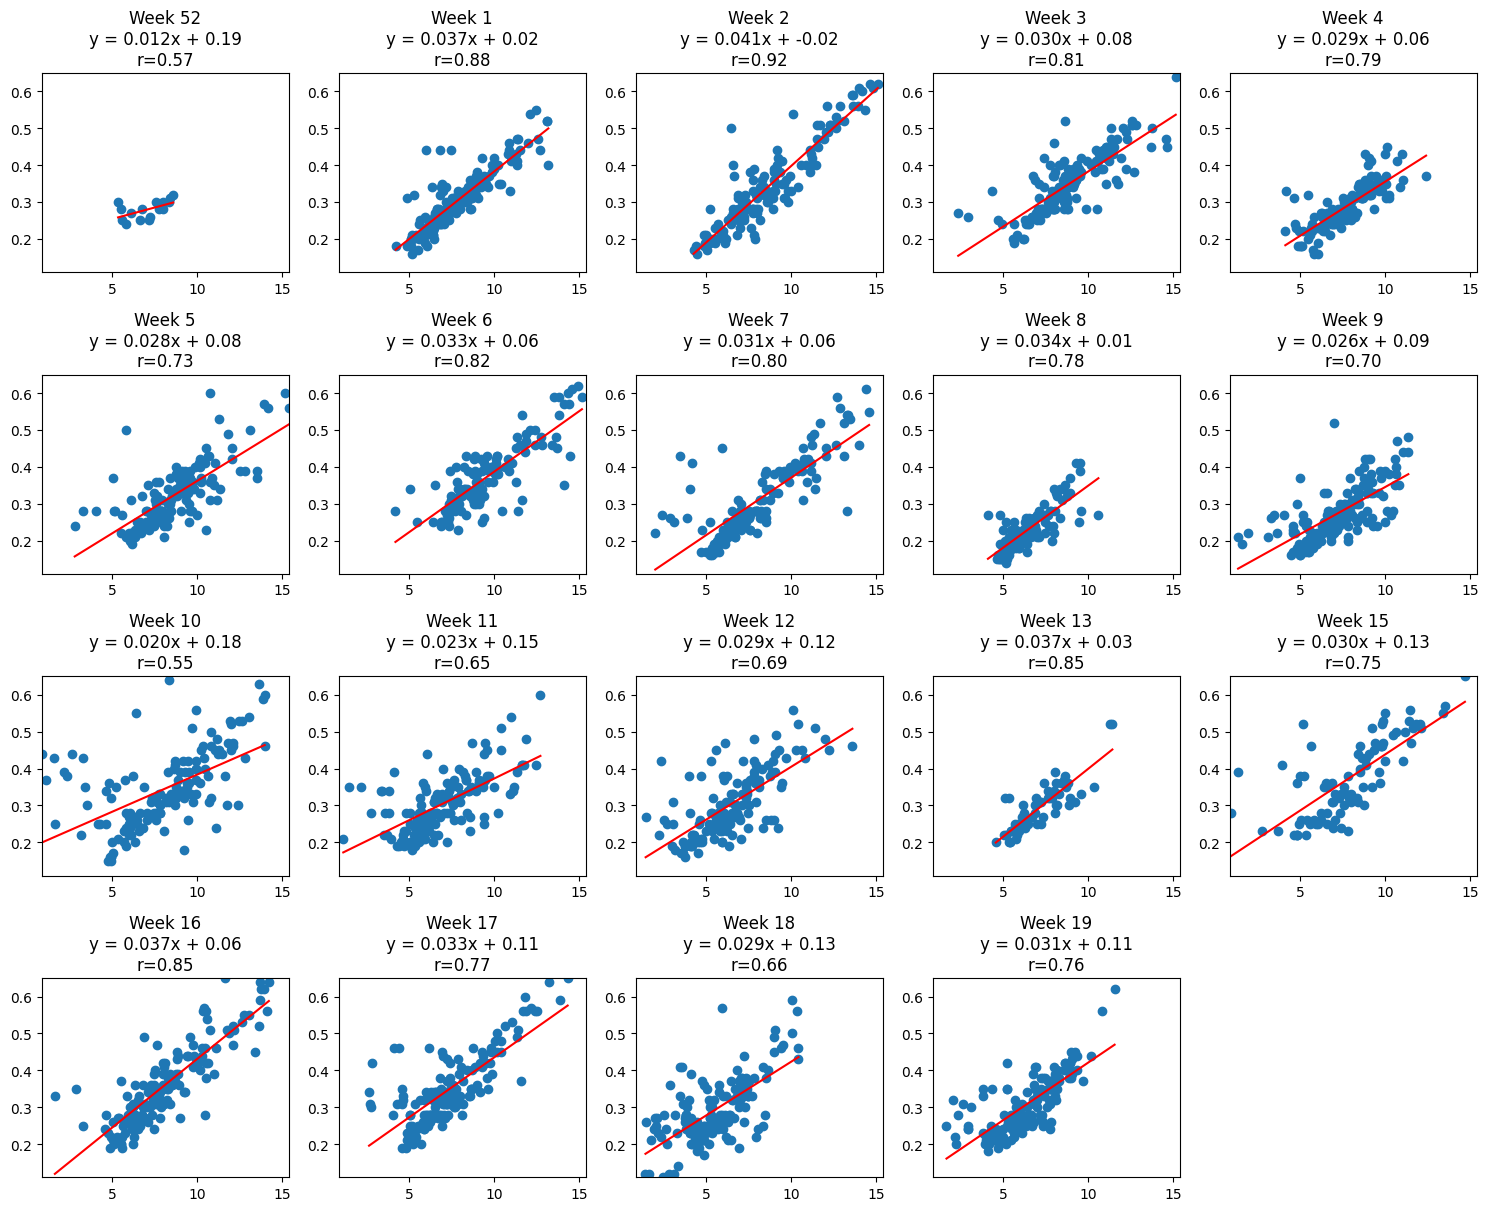

In [24]:
# Determine the grid size for subplots
grid_size = int(np.ceil(np.sqrt(df['week'].nunique())))

# Calculate the global minimum and maximum for sensor data and station data
global_x_min, global_x_max = df[f'SGX-{gas}'].min(), df[f'SGX-{gas}'].max()
global_y_min, global_y_max = df[f'REF-{gas}'].min(), df[f'REF-{gas}'].max()

fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

# Flatten the axis array to make indexing easier
axs = axs.flatten()

# Record the slope, r
slopes = []
rs = []

# For each week
for i, week in enumerate(df['week'].unique()):
    # Select the data for this week
    subset = df[df['week'] == week]
    
    # Create the scatter plot
    axs[i].scatter(subset[f'SGX-{gas}'], subset[f'REF-{gas}'])
    
    # Calculate the regression line parameters
    slope, intercept, r_value, p_value, std_err = linregress(subset[f'SGX-{gas}'], subset[f'REF-{gas}'])
    slopes.append(slope)
    rs.append(r_value)

    # Add the regression line
    x = np.linspace(subset[f'SGX-{gas}'].min(), subset[f'SGX-{gas}'].max())
    y = slope * x + intercept
    axs[i].plot(x, y, color='red')
    
    # Create the equation string
    equation = f'y = {slope:.3f}x + {intercept:.2f}'
    stats_text = f'r={r_value:.2f}'
    
    # Set the title to include the equation
    axs[i].set_title(f'Week {week}\n{equation}\n{stats_text}')

    # Set the x and y limits to the global minimum and maximum
    axs[i].set_xlim(global_x_min, global_x_max)
    axs[i].set_ylim(global_y_min, global_y_max)

# Remove extra subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


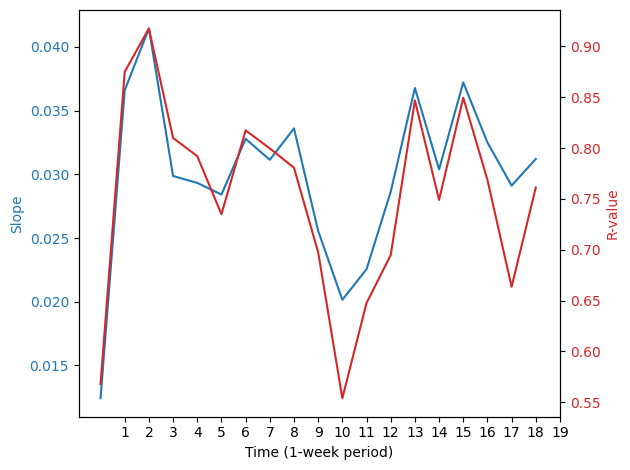

In [27]:
fig, ax1 = plt.subplots()

# Plot the slopes on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Time (1-week period)')
ax1.set_ylabel('Slope', color=color)
ax1.plot(slopes, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Set x-ticks to be the weeks of the year
xticks = list(range(1, len(slopes) + 1))
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)

# Create a second y-axis with the same x-axis
ax2 = ax1.twinx()

# Plot the r-values on the right y-axis
color = 'tab:red'
ax2.set_ylabel('R-value', color=color)
ax2.plot(rs, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set x-ticks to be the weeks of the year for the second y-axis
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks)

fig.tight_layout()
plt.show()


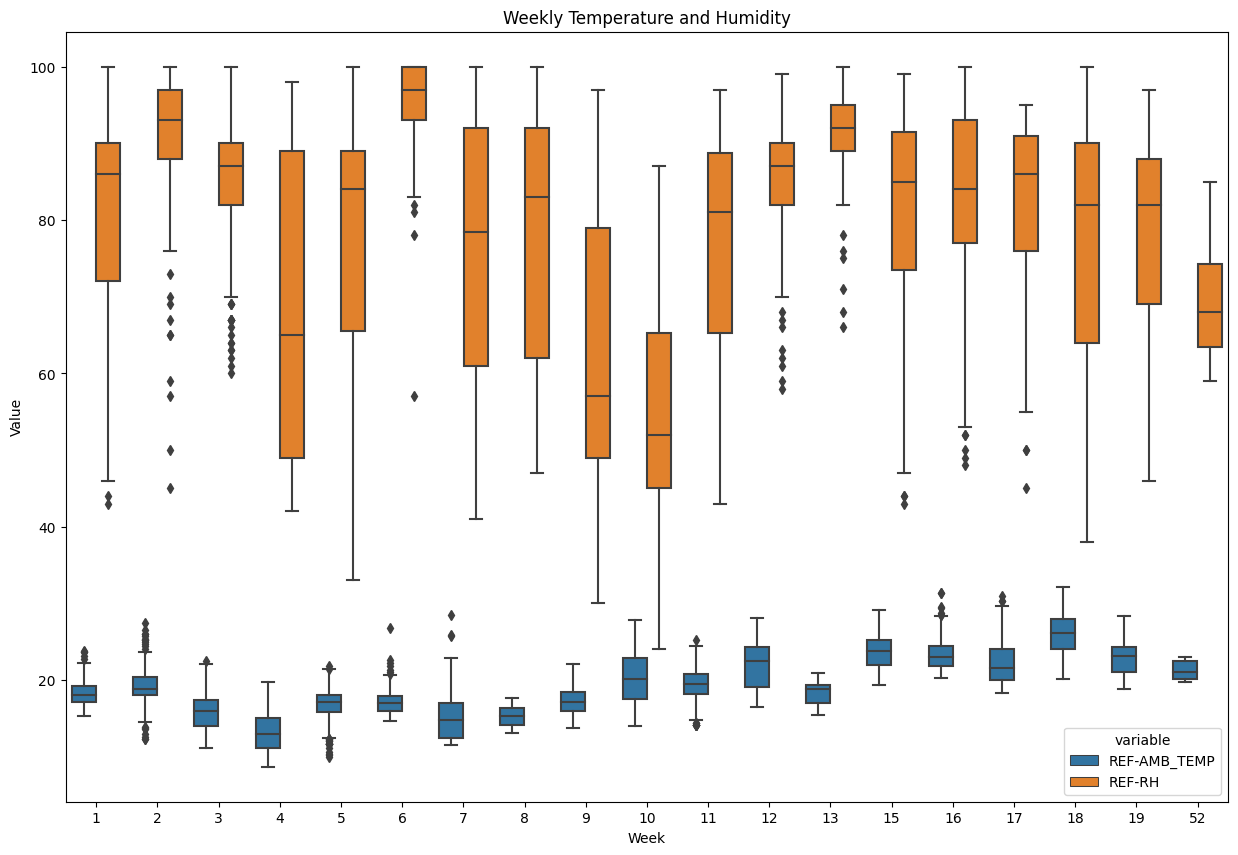

In [28]:


# Prepare the data
df_melted = df.melt(id_vars='week', value_vars=['REF-AMB_TEMP', 'REF-RH'])

# Create the boxplot
plt.figure(figsize=(15, 10))
sns.boxplot(x='week', y='value', hue='variable', data=df_melted)
plt.title('Weekly Temperature and Humidity')
plt.xlabel('Week')
plt.ylabel('Value')
plt.show()
